In [8]:
import timeit
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import os
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from sklearn.linear_model import Ridge, Lasso
from gensim.models import KeyedVectors
import scipy.stats as stats



# Clean and tokenize text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.model_selection import cross_val_score, KFold

nltk.download('stopwords') # download stopwords corpus
nltk.download('punkt') # download punkt tokenizer

# For linear regression
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Hannah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Hannah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
%cd /Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline

/Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline


## Linear Regression

Some layers from the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline: Mean Squared Error: 0.11406323900337804
Baseline: Variance of Squared Errors: 0.017718331689167994
Baseline: STD of Squared Errors: 0.13311022383411425
Baseline: MSE Confidence Interval (10%, 90%): (0.11198871138568861, 0.11618749275188647)


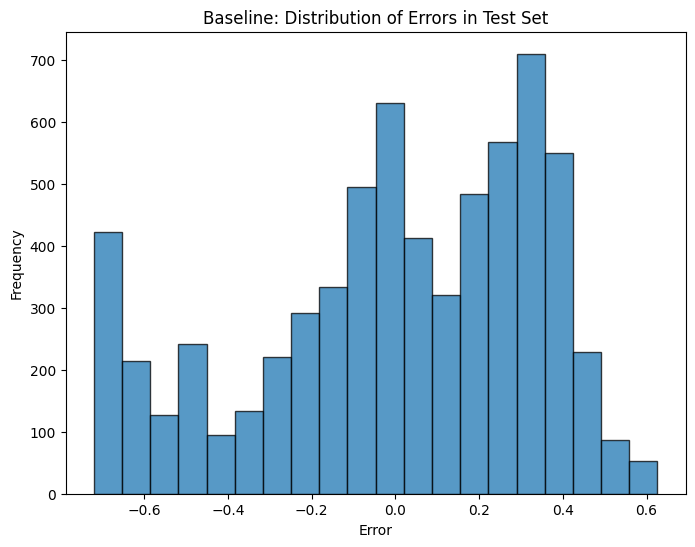

/var/folders/24/zyx78_1d5fndpjnbr8x7dd6r0000gn/T/ipykernel_55763/3745840142.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'embedding_{j}'] = embeddings[:, j]
/var/folders/24/zyx78_1d5fndpjnbr8x7dd6r0000gn/T/ipykernel_55763/3745840142.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'embedding_{j}'] = embeddings[:, j]
/var/folders/24/zyx78_1d5fndpjnbr8x7dd6r0000gn/T/ipykernel_55763/3745840142.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

Cross-Validation Scores: [-0.11642938 -0.1180527  -0.11352024 -0.12908461 -0.12575889]
Average Cross-Validation MSE: 0.12056916171073624


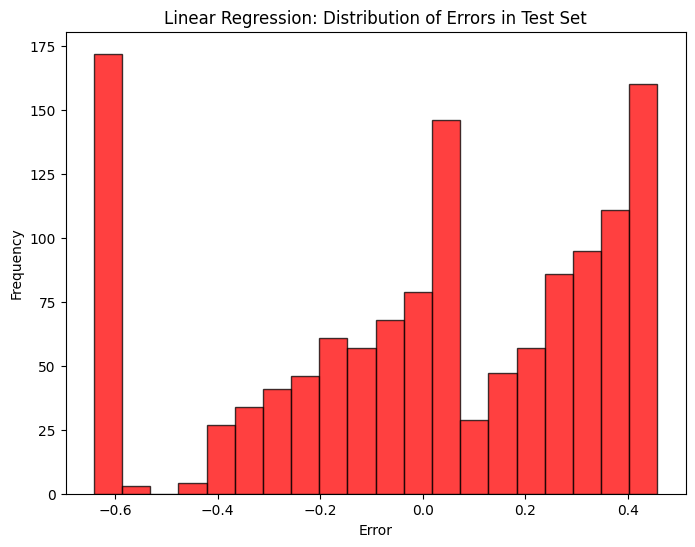

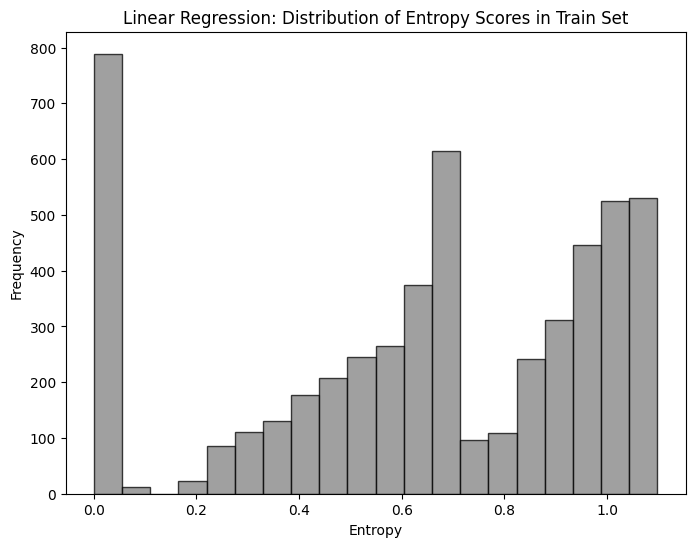

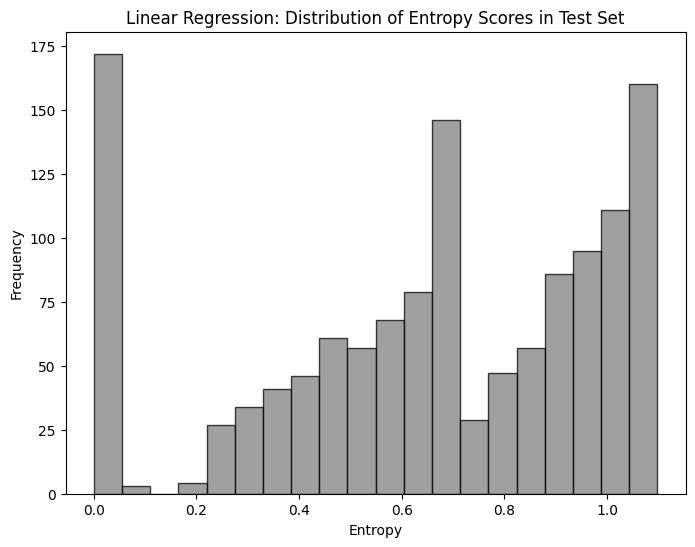

Linear Regression: Mean Squared Error: 0.1164
Linear Regression: R-squared: -0.00
Linear Regression: Variance of Errors: 0.1164
Linear Regression: Standard Deviation of Errors: 0.3411
Linear Regression: MSE Confidence Interval (10%, 90%): (0.11199065546484216, 0.12092774871543392)


In [10]:
# Transformer for reading CSV file into DataFrame
class CSVReader(BaseEstimator, TransformerMixin):
    def __init__(self, file_path):
        self.file_path = file_path
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(self.file_path)
        
        # Return the DataFrame
        return df

# Transformer for Gensim Dutch Word2Vec embeddings
class GensimEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self, model_path, embedding_size):
        self.model_path = model_path
        self.embedding_size = embedding_size
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Load the Gensim Word2Vec model
        model = KeyedVectors.load_word2vec_format(self.model_path)
        
        # Initialize an empty numpy array to store the embeddings
        embeddings = np.zeros((len(X), self.embedding_size))
        
        # Iterate over the words in the text and calculate the embeddings
        for i, word in enumerate(X['prep_content']):
            if word in model:
                embeddings[i, :] = model[word]
            else:
                embeddings[i, :] = np.random.randn(self.embedding_size)
        
        # Add the embeddings to the DataFrame
        for j in range(embeddings.shape[1]):
            X[f'embedding_{j}'] = embeddings[:, j]
        
        return X

# Transformer for TFIDF embeddings
class TFIDFEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer()
    
    def fit(self, X, y=None):
        self.tfidf_vectorizer.fit(X['prep_content'])
        return self
    
    def transform(self, X):
        # Fit the TF-IDF vectorizer if it's not fitted
        if not hasattr(self.tfidf_vectorizer, 'idf_'):
            self.fit(X)
        
        # Calculate the TF-IDF embeddings
        tfidf_embeddings = self.tfidf_vectorizer.transform(X['prep_content'])

        # Add the embeddings to the DataFrame
        for i in range(tfidf_embeddings.shape[1]):
            X[f'tfidf_embedding_{i}'] = tfidf_embeddings[:, i].toarray().flatten()
        
        n_features = len(self.tfidf_vectorizer.vocabulary_)

        return X, n_features
    
class BERTEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
        self.model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # Tensorflow
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embeddings = np.zeros((len(X), 768))
        for i, text in enumerate(X['content']):
            input_ids = self.tokenizer.encode(str(text), add_special_tokens=True, return_tensors="tf")
            output = self.model(input_ids)
            embeddings[i] = np.max(output.last_hidden_state.numpy(), axis=1)
        
        for j in range(embeddings.shape[1]):
            X[f'embedding_{j}'] = embeddings[:, j]
        
        return X    
 # Transformer for baseline model   
class BaselineAnalysis(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        avg_entropy_per_source = X.groupby('name')['entropy'].mean()
        X['avg_entropy'] = X['name'].map(avg_entropy_per_source)

        mse = mean_squared_error(X['entropy'], X['avg_entropy'])
        print("Baseline: Mean Squared Error:", mse)

        errors = X['entropy'] - X['avg_entropy']
        squared_errors = errors ** 2        
        variance = np.var(squared_errors)
        print("Baseline: Variance of Squared Errors:", variance)

        std = np.std(squared_errors)
        print("Baseline: STD of Squared Errors:", std)
        
        # Bootstrapping to calculate confidence intervals around MSE
        n_iterations = 1000  # Number of bootstrap iterations
        mse_bootstrapped = []
        for _ in range(n_iterations):
            # Resample the squared errors
            resampled_errors = np.random.choice(squared_errors, size=len(squared_errors), replace=True)
            # Calculate MSE from resampled errors
            mse_bootstrapped.append(np.mean(resampled_errors))

        # Calculate the lower and upper percentiles for confidence interval
        lower_percentile = 10  # 2.5th percentile
        upper_percentile = 90  # 97.5th percentile
        ci_lower = np.percentile(mse_bootstrapped, lower_percentile)
        ci_upper = np.percentile(mse_bootstrapped, upper_percentile)
        print(f"Baseline: MSE Confidence Interval ({lower_percentile}%, {upper_percentile}%): ({ci_lower}, {ci_upper})")

        plt.figure(figsize=(8, 6))
        plt.hist(errors, bins=20, edgecolor='black', alpha=0.75)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title('Baseline: Distribution of Errors in Test Set')
        plt.show()

        return X 
      
 # Transformer for Linear Regression    
class LinearRegressionAnalysis(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_option, regularization=None, alpha=1.0):
        self.embedding_option = embedding_option
        self.embedding_step = None
        self.regularization = regularization
        self.alpha = alpha
        self.model = None
    
    def fit(self, X, y=None):
        

        # Prepare the input features based on the chosen embedding option
        if self.embedding_option == 'gensim':
            self.embedding_step = GensimEmbeddings(model_path='/Users/Hannah/Downloads/160/combined-160.txt', embedding_size=160)
            X = self.embedding_step.transform(X)
            # Prepare the input features
            X_features = X.iloc[:, -160:]
        elif self.embedding_option == 'tfidf':
            self.embedding_step = TFIDFEmbeddings()
            X, n_features = self.embedding_step.transform(X)
            X_features = X.iloc[:, -n_features:]
        elif self.embedding_option == 'bert':
            self.embedding_step = BERTEmbeddings()
            X = self.embedding_step.transform(X)
            # Prepare the input features
            X_features = X.iloc[:, -768:]
        
        # Define and train the linear regression model
        if self.regularization == 'ridge':
            self.model = Ridge(alpha=self.alpha)
        elif self.regularization == 'lasso':
            self.model = Lasso(alpha=self.alpha)
        else:
            self.model = LinearRegression()
            
        # Prepare the target variable
        y_target = X['entropy']
        
        # Split the data into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)
        
        # Perform cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(self.model, X_features, y_target, scoring='neg_mean_squared_error', cv=cv)

        # Print the cross-validation scores
        print('Cross-Validation Scores:', scores)
        print('Average Cross-Validation MSE:', np.mean(scores))
        
        self.model.fit(self.X_train, self.y_train)
        
        return self
        
    def transform(self, X):
        if self.embedding_step is not None:
            X = self.embedding_step.transform(X)
    
        # Make predictions on the test set
        y_pred = self.model.predict(self.X_test)

        # Calculate the errors
        errors = self.y_test - y_pred
        
        # Plot the distribution of errors
        plt.figure(figsize=(8, 6))
        plt.hist(errors, bins=20, edgecolor='black', color='red', alpha=0.75)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title('Linear Regression: Distribution of Errors in Test Set')
        plt.show()
        
        # Plot the distribution of entropy scores in the Train set
        plt.figure(figsize=(8, 6))
        plt.hist(self.y_train, bins=20, edgecolor='black', color='grey', alpha=0.75)
        plt.xlabel('Entropy')
        plt.ylabel('Frequency')
        plt.title('Linear Regression: Distribution of Entropy Scores in Train Set')
        plt.show()
        
        # Plot the distribution of entropy scores in the Test set
        plt.figure(figsize=(8, 6))
        plt.hist(self.y_test, bins=20, edgecolor='black', color='grey', alpha=0.75)
        plt.xlabel('Entropy')
        plt.ylabel('Frequency')
        plt.title('Linear Regression: Distribution of Entropy Scores in Test Set')
        plt.show()
        
        # Evaluate model performance
        mse = mean_squared_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)
        var = np.var(errors)
        std = np.std(errors)
        
        # Print the evaluation metrics
        print(f'Linear Regression: Mean Squared Error: {mse:.4f}')
        print(f'Linear Regression: R-squared: {r2:.2f}')
        print(f'Linear Regression: Variance of Errors: {var:.4f}')
        print(f'Linear Regression: Standard Deviation of Errors: {std:.4f}')
        
        # Bootstrapping to calculate confidence intervals around MSE
        # Calculate the squared errors
        squared_errors = errors**2
        n_iterations = 1000  # Number of bootstrap iterations
        mse_bootstrapped = []
        for _ in range(n_iterations):
            # Resample the squared errors
            resampled_errors = np.random.choice(squared_errors, size=len(squared_errors), replace=True)
            # Calculate MSE from resampled errors
            mse_bootstrapped.append(np.mean(resampled_errors))

        # Calculate the lower and upper percentiles for confidence interval
        lower_percentile = 10  # 2.5th percentile
        upper_percentile = 90  # 97.5th percentile
        ci_lower = np.percentile(mse_bootstrapped, lower_percentile)
        ci_upper = np.percentile(mse_bootstrapped, upper_percentile)
        print(f"Linear Regression: MSE Confidence Interval ({lower_percentile}%, {upper_percentile}%): ({ci_lower}, {ci_upper})")
        
        return X

chosen_embedding = 'gensim'  # INPUT CHOSEN EMBEDDING HERE
chosen_regularization = 'lasso'  # INPUT CHOSEN REGULARIZATION ('ridge' or 'lasso')
alpha_value = 1.0  # INPUT ALPHA VALUE HERE

pipeline = Pipeline([
    ('csv_reader', CSVReader('Indicator-Desc_DataNewVanPipeline.csv')), # INPUT FILE
    ('baseline_analysis', BaselineAnalysis()),
    ('linear_regression', LinearRegressionAnalysis(embedding_option=chosen_embedding, regularization=chosen_regularization, alpha=alpha_value)),
])

embedding_options = {
    'gensim': GensimEmbeddings(model_path='/Users/Hannah/Downloads/160/combined-160.txt', embedding_size=160), #INPUT WORD2VEC MODEL PATH
    'tfidf': TFIDFEmbeddings(),
    'bert': BERTEmbeddings(),
}

pipeline.set_params(linear_regression__embedding_option=chosen_embedding)
df_transformed = pipeline.fit_transform(None)


In [6]:
# Get the indices of the test set
test_indices = X_test.index

# Retrieve the raw texts from the original dataframe using the test indices
raw_texts = df.loc[test_indices, 'content']

# Print the raw texts along with the corresponding predicted values
for text, pred in zip(raw_texts, y_pred):
    print(f"Text: {text}")
    print(f"Predicted Entropy: {pred}\n")


Text: Het is voor het eerst sinds 2009 dat in de halve finales alleen de publieksstemmen tellen, de jury speelt geen rol. In de finale telt het oordeel van de jury wel mee. NOS
Predicted Entropy: 0.5220547043466073

Text: Van Danzig toont zich geen wethouder Ruimtelijke Ordening, maar vooral een verdrietige projectontwikkelaar, schrijft Danny Edwards namens Voedselpark Amsterdam in een opiniestuk. Het Parool
Predicted Entropy: 0.4101146065729505

Text: Vanaf zondag laat de zon zich steeds meer zien. Maar je winterjas kan je nog nét niet wegleggen, want ondanks het zonnige weer wordt het wel koud  Metro Holland
Predicted Entropy: 0.5075380283531541

Text: De kinderombudsman van de metropoolregio Amsterdam, Anne Martien van der Does, neemt per 1 oktober afscheid. Het Parool
Predicted Entropy: 0.48854740815848396

Text: Na urenlang 'intensief en indringend' crisisberaad in een hotel bij Utrecht behoudt Hoekstra het vertrouwen van CDA’ers. Maar interne onvrede zal ook na dit overleg nog sm

In [16]:
import random
import random
from lime.lime_text import LimeTextExplainer

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')

print("Predicted entropy measure:", model.predict(np.array(['content']))[0])





/opt/anaconda3/envs/modelenv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=['2.296802759170532 1.088638186454773 1.062391757965088 0.7927981019020081 1.744913935661316 0.8388813734054565 1.2552924156188965 1.1379809379577637 0.7724339365959167 1.4172146320343018 1.503358006477356 1.5136827230453491 0.2220508605241775 0.7683473229408264 0.8038026690483093 1.3014247417449951 0.6353362798690796 1.1938644647598269 0.871186375617981 0.981575608253479 1.4727452993392944 1.443620204925537 0.9677345752716064 0.9988753199577332 1.71858811378479 0.9694809913635254 1.374146819114685 1.195363163948059 1.340049386024475 0.921678066253662 1.4264750480651855 1.6154841184616089 1.1327593326568604 0.8079197406768799 0.9794230461120604 1.051459550857544 1.560186505317688 2.336158514022827 1.5714826583862305 1.0976223945617676 1.2871997356414795 1.1053117513656616 1.4158520698547363 0.9874482154846193 1.1265711784362793 1.113481521606445 1.0090816020965576 1.4335112571716309 1.3616968393325806 1.5878024101257324 1.0360057353973389 0.1563935428857803 1.9880856275558472 0.7901890277862549 0.8226718902587891 1.1311084032058716 1.4745469093322754 1.7592376470565796 1.874279499053955 1.0577539205551147 1.472402811050415 1.214913010597229 0.7588405013084412 0.9711037278175354 1.5204633474349976 1.36228609085083 1.1419689655303955 1.1463943719863892 0.7769128680229187 1.2255163192749023 0.7749232649803162 0.9505065083503724 0.9328436851501464 1.241247296333313 1.7477387189865112 1.1397697925567627 1.517722725868225 0.4103766083717346 1.1370514631271362 1.7534029483795166 1.832739353179932 1.1031627655029297 0.7029612064361572 0.5709750652313232 1.1983835697174072 1.3877893686294556 0.5808175206184387 1.416530728340149 1.1025274991989136 0.4981144666671753 0.9978277087211608 1.7814133167266846 0.8769264817237854 1.262735366821289 0.6959702372550964 0.8276760578155518 0.86763596534729 1.1084673404693604 1.5403287410736084 0.7100105881690979 1.407630443572998 0.6167104840278625 0.9104470610618592 0.9529921412467957 1.6379083395004272 1.013686180114746 0.624518632888794 1.2518582344055176 0.9931690692901612 1.0959810018539429 1.6088314056396484 1.1063168048858645 2.092345952987671 1.047937273979187 0.6136753559112549 0.9945437908172609 1.3728044033050537 0.5986725687980652 1.4196417331695557 0.6398446559906006 0.93563574552536 1.1069897413253784 1.2490015029907229 1.705499291419983 1.0977976322174072 0.995488464832306 1.3081321716308594 0.5009253621101379 1.3336654901504517 1.3391801118850708 1.5857090950012207 0.1079620942473411 1.35673725605011 1.2865391969680786 0.6953948736190796 1.6313974857330322 1.37295663356781 0.5599797368049622 0.8114393949508667 0.8710013031959534 1.4076695442199707 1.1524596214294434 2.497629880905152 0.4853094220161438 0.9344747066497804 1.3192071914672852 1.8719570636749268 1.3953630924224854 2.186213254928589 1.1706241369247437 0.7178730964660645 1.279935359954834 1.071146845817566 1.2009023427963257 2.0285918712615967 0.8909189105033875 0.9566129446029664 1.0434222221374512 1.6641682386398315 0.8106256723403931 1.6999499797821045 1.3263336420059204 0.3502323627471924 1.4438532590866089 0.2424356490373611 1.0262013673782349 0.8521024584770203 0.6539396643638611 0.8909159302711487 1.088917255401611 0.9407053589820862 1.6920241117477417 0.2777272760868072 1.187134027481079 0.9393688440322876 2.479153871536255 0.8639896512031555 0.9433858394622804 0.9229300022125244 0.5891426801681519 1.1350162029266355 1.7363405227661133 0.9240845441818236 0.9121127724647522 1.1038044691085815 0.8094379901885986 1.3086826801300049 0.4105142951011657 1.4742707014083862 1.0686687231063845 1.2724082469940186 0.8480909466743469 0.3844184279441833 2.025683641433716 1.070560336112976 1.081931233406067 1.030645489692688 1.102964997291565 1.3314917087554932 1.3495737314224243 1.2088584899902344 1.93187153339386 1.121646523475647 0.6125527024269104 0.416971355676651 0.8919989466667175 1.5098211765289309 0.8336001634597778 0.8332722187042236 1.16459059715271 0.4503458738327026 0.9331648349761964 1.0649924278259275 0.2806630432605743 0.8347545862197876 1.540801167488098 0.7424602508544922 2.528093099594116 1.4362865686416626 0.8485594391822815 1.4165416955947876 1.4687391519546509 1.1377496719360352 0.8827868700027466 1.192966341972351 1.303465485572815 1.559462308883667 1.6286638975143433 1.2883402109146118 1.7883528470993042 1.516945719718933 1.1097078323364258 1.152186393737793 1.1522208452224731 0.7890892028808594 1.0864417552947998 0.3857313096523285 1.9567257165908811 1.1674503087997437 0.8263773322105408 0.8630608320236206 2.09449315071106 1.014654517173767 1.5663793087005615 1.662550687789917 1.302172064781189 1.025901436805725 0.595835268497467 1.4197828769683838 0.7806695699691772 1.744089126586914 0.9242444038391112 1.436568021774292 0.9615985155105592 0.6765908598899841 1.7598382234573364 0.7453632950782776 0.7444590926170349 1.402941346168518 1.1472313404083252 0.4724217653274536 0.5036157369613647 1.1287853717803955 0.7610850930213928 1.248268485069275 1.495145320892334 1.2814258337020874 1.5442646741867063 0.4387454986572265 1.197414755821228 1.0822362899780271 1.140647292137146 1.746626377105713 1.5361783504486084 1.551416277885437 0.6339988112449646 1.1004133224487305 1.5796654224395752 1.5159521102905271 0.9218262434005736 1.5971697568893433 0.9405664205551147 0.7092788219451904 0.7401615381240845 0.5386328101158142 0.7481059432029724 1.023072600364685 1.3263989686965942 0.855858325958252 1.0891578197479248 1.3325536251068115 1.3862448930740356 0.6297310590744019 0.8731756210327148 0.4600858092308044 2.09444522857666 0.9723553657531738 1.1446470022201538 0.9328656792640686 0.9672667384147644 1.9035874605178835 1.3941960334777832 0.9113662838935852 0.7182014584541321 1.2134355306625366 1.01069974899292 1.747236251831055 0.8080854415893555 1.1750465631484983 2.0498807430267334 1.1999646425247192 1.685725450515747 1.4439563751220703 0.5873280763626099 0.7635635733604431 1.601922631263733 1.525744915008545 1.9391039609909055 0.4659158289432525 0.9638949632644652 1.6495662927627563 1.5798275470733645 1.1009125709533691 1.2856749296188354 0.1240023672580719 2.7415976524353027 1.6248250007629397 2.038269281387329 1.4733794927597046 0.9038357734680176 1.0165789127349854 1.2227100133895874 1.3367658853530884 2.4598100185394287 0.802542507648468 1.3273824453353882 1.5313186645507812 0.9137980937957764 0.3084426522254944 1.3209550380706787 1.8576472997665403 1.574863314628601 1.0341380834579468 1.4223105907440186 0.7385619878768921 1.328433632850647 1.3012298345565796 1.614598274230957 0.7800792455673218 1.937238931655884 1.2087329626083374 0.9269923567771912 1.5505427122116089 0.5740398168563843 1.2078711986541748 1.0071923732757568 1.099603295326233 1.2125120162963867 0.8286605477333069 0.2401627898216247 0.3521029949188232 1.1374822854995728 0.7199854850769043 0.964784860610962 0.9474914073944092 0.6921907067298889 1.2232673168182373 1.2451367378234863 1.403519868850708 1.118877410888672 0.5989482998847961 0.4626687467098236 0.5796977281570435 1.5353665351867676 1.7378803491592407 1.7480937242507937 0.8172575831413269 1.273517370223999 0.7227764129638672 0.6894363760948181 0.8985127806663513 1.5782017707824707 1.194625735282898 7.81062126159668 1.195926547050476 1.1729817390441897 0.7649893760681152 0.9580373764038086 1.1316609382629397 1.213020086288452 1.8266170024871824 0.9005468487739563 2.0986549854278564 0.989046275615692 1.3031049966812134 1.2650083303451538 1.394864797592163 1.4915478229522705 0.4444253742694855 0.875605046749115 1.2413790225982666 0.3413043618202209 0.8528115153312683 1.2531088590621948 1.5676387548446655 0.3085618615150451 1.656751275062561 0.656129777431488 0.854485034942627 1.314259052276611 1.8652222156524656 1.377466082572937 0.5499590039253235 0.9895743131637572 0.3937108218669891 1.7923874855041504 0.7564024329185486 1.5901154279708862 0.6949701309204102 1.3715144395828247 1.2559504508972168 1.3466757535934448 0.9580377340316772 1.080413579940796 1.1799182891845703 0.5049840211868286 0.537318229675293 1.3608386516571045 1.239660620689392 1.010586142539978 1.2669223546981812 0.8782690763473511 0.810293972492218 1.7228397130966189 0.7541036605834961 1.14166522026062 1.6679937839508057 0.7999411821365356 0.856092631816864 0.5886903405189514 0.9590336084365844 1.0469177961349487 1.29363751411438 0.994682550430298 1.5001893043518066 1.082886815071106 1.0424338579177856 0.8530325889587402 1.3578554391860962 0.5773417353630066 1.3756755590438845 1.190225601196289 1.0523381233215332 1.3713665008544922 1.9557504653930664 1.5924322605133057 1.0057868957519531 0.9107918739318848 1.7950900793075562 1.3347214460372925 0.9832736253738404 0.9284217953681946 1.2307243347167969 1.3171355724334717 1.3074840307235718 0.8148230314254761 1.4958267211914062 0.9259098768234252 0.8757634162902832 1.2902992963790894 0.562690258026123 1.4971308708190918 0.8561561107635498 0.5329872369766235 1.1943600177764893 1.9489898681640625 1.281296730041504 0.5075790882110596 1.0489543676376345 1.4707316160202026 1.8872313499450684 0.5141552090644836 0.8636457324028015 0.8714762926101685 0.952710747718811 1.36680269241333 0.5392640233039856 0.6423007845878601 1.6101287603378296 1.0191943645477295 0.9148116111755372 0.9107773303985596 -0.0344771593809127 1.0742602348327637 1.2452503442764282 1.2293107509613037 1.6374876499176023 1.6401723623275757 0.7735331058502197 1.4281359910964966 1.9333549737930296 1.2097511291503906 1.500126600265503 1.405219554901123 2.574989557266236 1.2207534313201904 1.776601791381836 0.6042115688323975 1.1830769777297974 0.5532770156860352 0.7046879529953003 0.7255941033363342 0.4479677081108093 0.921245276927948 0.6139834523200989 0.9812057614326476 1.020455002784729 0.7883599400520325 1.3025048971176147 1.7280139923095703 0.9388550519943236 1.59427809715271 1.3889226913452148 0.8457677364349365 0.8815922141075134 1.2087061405181885 1.1308977603912354 1.0023868083953855 1.3110215663909912 0.6150539517402649 1.1451609134674072 0.8748337030410767 1.1521717309951782 0.8888693451881409 0.9134905338287354 0.7500200271606445 1.1767921447753906 1.8263453245162964 0.584006667137146 0.6220906376838684 0.6737200617790222 1.1395083665847778 1.2971841096878052 0.7694107890129089 1.280958652496338 0.8456296324729919 0.9674233198165894 1.1555601358413696 0.9522156715393066 0.788233757019043 0.3070582151412964 1.071178913116455 0.9871255159378052 0.274789810180664 0.8273369073867798 0.4300072193145752 1.1869282722473145 1.4551960229873655 0.7056304812431335 1.0365325212478638 1.2361714839935305 0.5103511810302734 1.5778353214263916 0.8828293681144714 0.574864387512207 1.8344093561172483 1.2508589029312134 1.0859423875808716 0.9332629442214966 1.4415550231933594 1.8356246948242188 0.8538695573806763 0.8201137781143188 1.315901517868042 1.5130671262741089 1.7662614583969116 0.9274819493293762 1.4747889041900637 1.2635066509246826 4.214592456817627 1.2904490232467651 0.4590887427330017 0.9536372423171996 0.7846100926399231 0.9266713857650756 0.5452082753181458 0.8349647521972656 0.7532801628112793 1.4016555547714231 1.49731707572937 1.2780823707580566 1.2564018964767456 0.9406965970993042 0.9973881244659424 0.8545823693275452 0.9582509398460388 1.5521727800369265 1.6425317525863647 0.5635437965393066 0.617629885673523 1.0909587144851685 1.7927922010421753 1.7044644355773926 1.1076830625534058 0.7056748867034912 1.785298466682434 0.8258503079414368 1.0862270593643188 1.4299277067184448 1.3947734832763672 1.3112094402313232 0.8606443405151367 1.44074285030365 1.2113680839538574 1.130898356437683 0.8012598752975464 1.9593912363052368 0.9517968893051147 1.7318052053451538 0.3408086597919464 1.4114238023757937 0.5592090487480164 1.0561139583587646 1.270046591758728 1.408532738685608 1.055695652961731 1.191490888595581 1.1129744052886963 0.7889453172683716 0.8617709279060364 1.2072489261627195 0.8592082858085632 0.6715743541717529 0.798882782459259 1.4007514715194702 0.9851651787757874 0.8181767463684082 0.9167646169662476 0.6110297441482544 1.322398066520691 1.3046026229858398 0.9961534738540648 0.9168357849121094 1.798995852470398 0.8469460606575012 0.9210559129714966 0.8731118440628052 1.212741494178772 1.8670625686645508 1.5931024551391602 1.5289924144744873 1.3008482456207275 1.0166186094284058 1.1489228010177612 0.9284465312957764 1.4800854921340942 0.8803348541259766 1.0753607749938965 1.508832573890686 2.137608051300049 0.3288120031356811 0.7700456380844116 1.3269414901733398 1.1819264888763428 1.13411545753479 1.142192840576172 0.6836661100387573 1.6700470447540283 1.8120237588882449 1.2670621871948242 1.2396531105041504 0.9416714310646056 0.9402201771736144 1.1396030187606812 2.04666805267334 1.2689213752746582 0.9567093849182128 0.9721633195877076 1.0456759929656982 1.0115264654159546 0.1676376014947891 1.7628755569458008 0.8168065547943115 1.2610609531402588 1.2997955083847046 0.6524477601051331 1.2504918575286863 0.8045289516448975 1.0750519037246704 1.5933787822723389 1.061651587486267 0.7137437462806702 0.7938844561576843 1.0370630025863647 1.321823239326477 1.7788654565811155 0.9515945911407472 1.902214765548706 1.0699490308761597 1.609986424446106 1.8709505796432493 0.5363345146179199 0.9794331192970276 0.6884101033210754 1.095659852027893 0.527696967124939 1.6334185600280762 1.0005542039871216 1.072351098060608 1.4586220979690552 1.667589783668518 0.7923489809036255 0.5997377038002014 1.2950767278671265 0.8863743543624878 0.9247554540634156 2.070032119750977 0.9541590213775636 1.208251714706421 2.03960919380188 1.129105567932129 -0.3877289593219757 0.7264056205749512 0.9960818886756896 1.3994393348693848 1.2638912200927734 1.8376638889312744 0.8417672514915466 0.5952425599098206 2.14471435546875 1.2519090175628662 1.5509448051452637 1.210814356803894 1.3770736455917358 0.79573655128479 1.4198248386383057 0.6027817726135254 0.8143725991249084 0.5447049736976624 0.7400486469268799 0.9571555852890016 0.8883207440376282 1.1581556797027588 0.4727431535720825 0.4334246516227722 1.2825968265533447 1.398191213607788 1.428606033325195 0.9450326561927797 1.4669982194900513 0.3631686568260193 1.7262814044952393 1.9636378288269043 0.8170749545097351 1.3553881645202637 1.4588682651519775 1.613275170326233 0.8273656964302063 0.9931853413581848 13.25784969329834 0.9762486219406128 0.8809220790863037 0.8754347562789917 1.1343766450881958 0.8405161499977112 0.5878155827522278 0.5511088967323303 1.1924623250961304'
 '2.296802759170532 1.088638186454773 1.062391757965088 0.7927981019020081 1. 0. 1.2552924156188965 1.1379809379577637 0.7724339365959167 1.4172146320343018 1.503358006477356 1.5136827230453491 0.2220508605241775 0.7683473229408264 0.8038026690483093 1.3014247417449951 0.6353362798690796 1.1938644647598269 0.871186375617981 0. 1.4727452993392944 1.443620204925537 0.9677345752716064 0.9988753199577332 1. 0. 1.374146819114685 1.195363163948059 1.340049386024475 0.921678066253662 1.4264750480651855 1.6154841184616089 1.1327593326568604 0.8079197406768799 0.9794230461120604 1.051459550857544 1. 2.336158514022827 1.5714826583862305 1.0976223945617676 1.2871997356414795 1.1053117513656616 1. 0.9874482154846193 1.1265711784362793 1.113481521606445 1. 1.4335112571716309 1.3616968393325806 1. 1.0360057353973389 0. 1.9880856275558472 0.7901890277862549 0.8226718902587891 1. 1.4745469093322754 1.7592376470565796 1.874279499053955 1.0577539205551147 1.472402811050415 1.214913010597229 0.7588405013084412 0.9711037278175354 1.5204633474349976 1.36228609085083 1.1419689655303955 1.1463943719863892 0.7769128680229187 1.2255163192749023 0. 0.9505065083503724 0.9328436851501464 1.241247296333313 1. 1. 1.517722725868225 0.4103766083717346 1. 1.7534029483795166 1.832739353179932 1.1031627655029297 0.7029612064361572 0.5709750652313232 1.1983835697174072 1.3877893686294556 0.5808175206184387 1. 1.1025274991989136 0.4981144666671753 0.9978277087211608 1.7814133167266846 0.8769264817237854 1.262735366821289 0. 0.8276760578155518 0. 1.1084673404693604 1.5403287410736084 0. 1.407630443572998 0.6167104840278625 0.9104470610618592 0. 1.6379083395004272 1.013686180114746 0.624518632888794 1.2518582344055176 0.9931690692901612 1.0959810018539429 1.6088314056396484 1.1063168048858645 2.092345952987671 1. 0.6136753559112549 0.9945437908172609 1.3728044033050537 0.5986725687980652 1.4196417331695557 0.6398446559906006 0.93563574552536 1.1069897413253784 1.2490015029907229 1.705499291419983 1.0977976322174072 0.995488464832306 1.3081321716308594 0.5009253621101379 1.3336654901504517 1.3391801118850708 1. 0.1079620942473411 1.35673725605011 1.2865391969680786 0.6953948736190796 1.6313974857330322 1.37295663356781 0.5599797368049622 0.8114393949508667 0.8710013031959534 1.4076695442199707 1.1524596214294434 2.497629880905152 0.4853094220161438 0.9344747066497804 1.3192071914672852 1.8719570636749268 1.3953630924224854 2.186213254928589 1.1706241369247437 0.7178730964660645 1.279935359954834 1.071146845817566 1.2009023427963257 2.0285918712615967 0.8909189105033875 0.9566129446029664 1.0434222221374512 1.6641682386398315 0.8106256723403931 1.6999499797821045 1.3263336420059204 0.3502323627471924 1.4438532590866089 0. 1.0262013673782349 0.8521024584770203 0.6539396643638611 0.8909159302711487 1.088917255401611 0.9407053589820862 1.6920241117477417 0.2777272760868072 1. 0.9393688440322876 2.479153871536255 0.8639896512031555 0. 0.9229300022125244 0.5891426801681519 1.1350162029266355 1.7363405227661133 0.9240845441818236 0.9121127724647522 1. 0.8094379901885986 1.3086826801300049 0.4105142951011657 1.4742707014083862 1.0686687231063845 1.2724082469940186 0.8480909466743469 0. 2. 1.070560336112976 1.081931233406067 1.030645489692688 1.102964997291565 1.3314917087554932 1.3495737314224243 1.2088584899902344 1.93187153339386 1.121646523475647 0.6125527024269104 0.416971355676651 0.8919989466667175 1.5098211765289309 0. 0.8332722187042236 1.16459059715271 0.4503458738327026 0.9331648349761964 1.0649924278259275 0.2806630432605743 0.8347545862197876 1.540801167488098 0.7424602508544922 2. 1.4362865686416626 0.8485594391822815 1.4165416955947876 1.4687391519546509 1. 0.8827868700027466 1.192966341972351 1.303465485572815 1.559462308883667 1.6286638975143433 1.2883402109146118 1.7883528470993042 1.516945719718933 1. 1.152186393737793 1.1522208452224731 0.7890892028808594 1.0864417552947998 0.3857313096523285 1.9567257165908811 1.1674503087997437 0.8263773322105408 0.8630608320236206 2.09449315071106 1.014654517173767 1.5663793087005615 1.662550687789917 1.302172064781189 1.025901436805725 0.595835268497467 1.4197828769683838 0.7806695699691772 1.744089126586914 0.9242444038391112 1.436568021774292 0.9615985155105592 0.6765908598899841 1.7598382234573364 0.7453632950782776 0.7444590926170349 1.402941346168518 1. 0. 0.5036157369613647 1.1287853717803955 0.7610850930213928 1. 1.495145320892334 1.2814258337020874 1.5442646741867063 0.4387454986572265 1.197414755821228 1.0822362899780271 1.140647292137146 1.746626377105713 1. 1.551416277885437 0.6339988112449646 1. 1.5796654224395752 1. 0.9218262434005736 1.5971697568893433 0.9405664205551147 0.7092788219451904 0.7401615381240845 0.5386328101158142 0.7481059432029724 1.023072600364685 1.3263989686965942 0.855858325958252 1.0891578197479248 1.3325536251068115 1.3862448930740356 0. 0.8731756210327148 0.4600858092308044 2.09444522857666 0.9723553657531738 1.1446470022201538 0.9328656792640686 0.9672667384147644 1.9035874605178835 1.3941960334777832 0.9113662838935852 0.7182014584541321 1.2134355306625366 1.01069974899292 1.747236251831055 0.8080854415893555 1.1750465631484983 2.0498807430267334 1. 1. 1.4439563751220703 0. 0.7635635733604431 1.601922631263733 1.525744915008545 1.9391039609909055 0.4659158289432525 0.9638949632644652 1.6495662927627563 1.5798275470733645 1.1009125709533691 1.2856749296188354 0.1240023672580719 2.7415976524353027 1.6248250007629397 2. 1.4733794927597046 0.9038357734680176 1.0165789127349854 1.2227100133895874 1.3367658853530884 2.4598100185394287 0.802542507648468 1.3273824453353882 1.5313186645507812 0.9137980937957764 0.3084426522254944 1.3209550380706787 1.8576472997665403 1.574863314628601 1.0341380834579468 1.4223105907440186 0.7385619878768921 1.328433632850647 1.3012298345565796 1.614598274230957 0.7800792455673218 1.937238931655884 1.2087329626083374 0.9269923567771912 1.5505427122116089 0.5740398168563843 1.2078711986541748 1.0071923732757568 1.099603295326233 1.2125120162963867 0.8286605477333069 0.2401627898216247 0.3521029949188232 1.1374822854995728 0.7199854850769043 0.964784860610962 0.9474914073944092 0.6921907067298889 1.2232673168182373 1.2451367378234863 1.403519868850708 1.118877410888672 0.5989482998847961 0.4626687467098236 0. 1.5353665351867676 1.7378803491592407 1.7480937242507937 0.8172575831413269 1.273517370223999 0.7227764129638672 0.6894363760948181 0.8985127806663513 1.5782017707824707 1.194625735282898 7. 1.195926547050476 1.1729817390441897 0.7649893760681152 0.9580373764038086 1.1316609382629397 1.213020086288452 1.8266170024871824 0.9005468487739563 2. 0. 1.3031049966812134 1.2650083303451538 1.394864797592163 1.4915478229522705 0.4444253742694855 0.875605046749115 1.2413790225982666 0.3413043618202209 0.8528115153312683 1.2531088590621948 1.5676387548446655 0.3085618615150451 1.656751275062561 0.656129777431488 0.854485034942627 1.314259052276611 1.8652222156524656 1.377466082572937 0.5499590039253235 0.9895743131637572 0.3937108218669891 1.7923874855041504 0.7564024329185486 1.5901154279708862 0.6949701309204102 1.3715144395828247 1.2559504508972168 1.3466757535934448 0.9580377340316772 1.080413579940796 1.1799182891845703 0.5049840211868286 0.537318229675293 1.3608386516571045 1.239660620689392 1.010586142539978 1. 0.8782690763473511 0.810293972492218 1.7228397130966189 0.7541036605834961 1.14166522026062 1.6679937839508057 0.7999411821365356 0.856092631816864 0.5886903405189514 0.9590336084365844 1.0469177961349487 1.29363751411438 0.994682550430298 1.5001893043518066 1.082886815071106 1.0424338579177856 0.8530325889587402 1.3578554391860962 0. 1.3756755590438845 1.190225601196289 1.0523381233215332 1.3713665008544922 1.9557504653930664 1.5924322605133057 1.0057868957519531 0.9107918739318848 1.7950900793075562 1.3347214460372925 0.9832736253738404 0.9284217953681946 1.2307243347167969 1.3171355724334717 1.3074840307235718 0.8148230314254761 1.4958267211914062 0.9259098768234252 0. 1.2902992963790894 0. 1.4971308708190918 0.8561561107635498 0.5329872369766235 1.1943600177764893 1.9489898681640625 1.281296730041504 0.5075790882110596 1.0489543676376345 1.4707316160202026 1.8872313499450684 0.5141552090644836 0.8636457324028015 0.8714762926101685 0.952710747718811 1.36680269241333 0. 0. 1. 1.0191943645477295 0.9148116111755372 0.9107773303985596 -0.0344771593809127 1.0742602348327637 1.2452503442764282 1.2293107509613037 1.6374876499176023 1.6401723623275757 0.7735331058502197 1.4281359910964966 1.9333549737930296 1.2097511291503906 1.500126600265503 1. 2.574989557266236 1.2207534313201904 1.776601791381836 0.6042115688323975 1.1830769777297974 0.5532770156860352 0.7046879529953003 0. 0.4479677081108093 0. 0. 0.9812057614326476 1.020455002784729 0.7883599400520325 1.3025048971176147 1.7280139923095703 0.9388550519943236 1. 1.3889226913452148 0.8457677364349365 0.8815922141075134 1.2087061405181885 1.1308977603912354 1. 1.3110215663909912 0. 1.1451609134674072 0.8748337030410767 1.1521717309951782 0.8888693451881409 0.9134905338287354 0.7500200271606445 1.1767921447753906 1.8263453245162964 0. 0.6220906376838684 0.6737200617790222 1.1395083665847778 1. 0.7694107890129089 1.280958652496338 0.8456296324729919 0.9674233198165894 1.1555601358413696 0.9522156715393066 0.788233757019043 0. 1. 0.9871255159378052 0.274789810180664 0.8273369073867798 0. 1.1869282722473145 1. 0. 1.0365325212478638 1.2361714839935305 0.5103511810302734 1.5778353214263916 0.8828293681144714 0.574864387512207 1.8344093561172483 1.2508589029312134 1.0859423875808716 0.9332629442214966 1.4415550231933594 1.8356246948242188 0.8538695573806763 0. 1.315901517868042 1.5130671262741089 1.7662614583969116 0.9274819493293762 1. 1.2635066509246826 4.214592456817627 1. 0.4590887427330017 0.9536372423171996 0.7846100926399231 0. 0.5452082753181458 0.8349647521972656 0.7532801628112793 1.4016555547714231 1.49731707572937 1.2780823707580566 1.2564018964767456 0.9406965970993042 0.9973881244659424 0.8545823693275452 0.9582509398460388 1.5521727800369265 1.6425317525863647 0.5635437965393066 0.617629885673523 1.0909587144851685 1.7927922010421753 1.7044644355773926 1.1076830625534058 0.7056748867034912 1.785298466682434 0. 1.0862270593643188 1.4299277067184448 1.3947734832763672 1.3112094402313232 0.8606443405151367 1.44074285030365 1.2113680839538574 1.130898356437683 0. 1. 0.9517968893051147 1. 0. 1.4114238023757937 0.5592090487480164 1.0561139583587646 1.270046591758728 1.408532738685608 1.055695652961731 1. 1.1129744052886963 0.7889453172683716 0.8617709279060364 1.2072489261627195 0.8592082858085632 0.6715743541717529 0.798882782459259 1.4007514715194702 0.9851651787757874 0.8181767463684082 0.9167646169662476 0. 1.322398066520691 1.3046026229858398 0.9961534738540648 0. 1.798995852470398 0.8469460606575012 0.9210559129714966 0.8731118440628052 1.212741494178772 1.8670625686645508 1.5931024551391602 1.5289924144744873 1.3008482456207275 1.0166186094284058 1.1489228010177612 0. 1.4800854921340942 0. 1.0753607749938965 1.508832573890686 2.137608051300049 0.3288120031356811 0.7700456380844116 1. 1.1819264888763428 1.13411545753479 1.142192840576172 0. 1.6700470447540283 1.8120237588882449 1.2670621871948242 1.2396531105041504 0. 0. 1.1396030187606812 2. 1.2689213752746582 0.9567093849182128 0.9721633195877076 1.0456759929656982 1. 0.1676376014947891 1. 0. 1.2610609531402588 1.2997955083847046 0.6524477601051331 1.2504918575286863 0.8045289516448975 1.0750519037246704 1. 1.061651587486267 0.7137437462806702 0.7938844561576843 1.0370630025863647 1.321823239326477 1. 0.9515945911407472 1.902214765548706 1.0699490308761597 1.609986424446106 1.8709505796432493 0.5363345146179199 0.9794331192970276 0.6884101033210754 1.095659852027893 0. 1.6334185600280762 1.0005542039871216 1.072351098060608 1.4586220979690552 1.667589783668518 0.7923489809036255 0.5997377038002014 1.2950767278671265 0.8863743543624878 0.9247554540634156 2.070032119750977 0.9541590213775636 1.208251714706421 2.03960919380188 1.129105567932129 -0.3877289593219757 0.7264056205749512 0.9960818886756896 1.3994393348693848 1. 1.8376638889312744 0.8417672514915466 0.5952425599098206 2.14471435546875 1.2519090175628662 1.5509448051452637 1.210814356803894 1.3770736455917358 0.79573655128479 1.4198248386383057 0.6027817726135254 0.8143725991249084 0.5447049736976624 0.7400486469268799 0.9571555852890016 0.8883207440376282 1.1581556797027588 0. 0.4334246516227722 1.2825968265533447 1.398191213607788 1.428606033325195 0.9450326561927797 1.4669982194900513 0. 1.7262814044952393 1.9636378288269043 0.8170749545097351 1.3553881645202637 1.4588682651519775 1.613275170326233 0.8273656964302063 0.9931853413581848 13.25784969329834 0.9762486219406128 0.8809220790863037 0.8754347562789917 1.1343766450881958 0.8405161499977112 0. 0.5511088967323303 1.1924623250961304'
 '.296802759170532 1.088638186454773 1. . 1. . 1.2552924156188965 1.1379809379577637 .7724339365959167 1. 1.503358006477356 1.5136827230453491 .2220508605241775 .7683473229408264 .8038026690483093 1. .6353362798690796 1.1938644647598269 .871186375617981 .981575608253479 1. 1. . .9988753199577332 1.71858811378479 .9694809913635254 1.374146819114685 1. 1.340049386024475 .921678066253662 1.4264750480651855 1.6154841184616089 1. .8079197406768799 .9794230461120604 1.051459550857544 1.560186505317688 . 1.5714826583862305 1. 1.2871997356414795 1.1053117513656616 1.4158520698547363 .9874482154846193 1. 1. 1. 1.4335112571716309 1. 1. 1.0360057353973389 . 1. .7901890277862549 .8226718902587891 1.1311084032058716 1.4745469093322754 1. 1.874279499053955 1.0577539205551147 1.472402811050415 1. . .9711037278175354 1. 1.36228609085083 1. 1. .7769128680229187 1.2255163192749023 . .9505065083503724 .9328436851501464 1.241247296333313 1.7477387189865112 1.1397697925567627 1. .4103766083717346 1.1370514631271362 1. 1.832739353179932 1.1031627655029297 .7029612064361572 .5709750652313232 1. 1.3877893686294556 . 1.416530728340149 1.1025274991989136 .4981144666671753 .9978277087211608 1.7814133167266846 .8769264817237854 1.262735366821289 .6959702372550964 . .86763596534729 1.1084673404693604 1.5403287410736084 .7100105881690979 1.407630443572998 .6167104840278625 . .9529921412467957 1. 1. .624518632888794 1.2518582344055176 .9931690692901612 1.0959810018539429 1.6088314056396484 1.1063168048858645 .092345952987671 1.047937273979187 .6136753559112549 .9945437908172609 1.3728044033050537 .5986725687980652 1. .6398446559906006 . 1.1069897413253784 1.2490015029907229 1. 1.0977976322174072 .995488464832306 1. .5009253621101379 1.3336654901504517 1.3391801118850708 1.5857090950012207 .1079620942473411 1.35673725605011 1.2865391969680786 . 1.6313974857330322 1.37295663356781 .5599797368049622 . . 1. 1.1524596214294434 .497629880905152 .4853094220161438 .9344747066497804 1.3192071914672852 1.8719570636749268 1.3953630924224854 .186213254928589 1.1706241369247437 . 1.279935359954834 1.071146845817566 1. .0285918712615967 .8909189105033875 .9566129446029664 1.0434222221374512 1.6641682386398315 .8106256723403931 1.6999499797821045 1.3263336420059204 .3502323627471924 1. . 1. . . . 1.088917255401611 .9407053589820862 1. .2777272760868072 1. .9393688440322876 .479153871536255 .8639896512031555 . .9229300022125244 .5891426801681519 1. 1.7363405227661133 . .9121127724647522 1. .8094379901885986 1.3086826801300049 .4105142951011657 1.4742707014083862 1.0686687231063845 1.2724082469940186 .8480909466743469 .3844184279441833 .025683641433716 1.070560336112976 1.081931233406067 1.030645489692688 1. 1.3314917087554932 1.3495737314224243 1. 1.93187153339386 1.121646523475647 .6125527024269104 .416971355676651 .8919989466667175 1.5098211765289309 .8336001634597778 .8332722187042236 1.16459059715271 .4503458738327026 . 1.0649924278259275 .2806630432605743 .8347545862197876 1.540801167488098 .7424602508544922 .528093099594116 1. . 1.4165416955947876 1.4687391519546509 1.1377496719360352 .8827868700027466 1.192966341972351 1.303465485572815 1. 1.6286638975143433 1.2883402109146118 1.7883528470993042 1. 1.1097078323364258 1.152186393737793 1. .7890892028808594 1.0864417552947998 .3857313096523285 1.9567257165908811 1.1674503087997437 .8263773322105408 .8630608320236206 .09449315071106 1. 1.5663793087005615 1.662550687789917 1. 1. .595835268497467 1. . 1. .9242444038391112 1. .9615985155105592 .6765908598899841 1.7598382234573364 .7453632950782776 .7444590926170349 1. 1. .4724217653274536 .5036157369613647 1. .7610850930213928 1. 1.495145320892334 1.2814258337020874 1. . 1.197414755821228 1.0822362899780271 1.140647292137146 1.746626377105713 1. 1.551416277885437 . 1.1004133224487305 1.5796654224395752 1.5159521102905271 .9218262434005736 1. .9405664205551147 . .7401615381240845 .5386328101158142 . 1.023072600364685 1.3263989686965942 .855858325958252 1.0891578197479248 1. 1. .6297310590744019 . . .09444522857666 .9723553657531738 1.1446470022201538 .9328656792640686 . 1. 1. .9113662838935852 .7182014584541321 1. 1.01069974899292 1.747236251831055 .8080854415893555 1.1750465631484983 .0498807430267334 1. 1.685725450515747 1. . .7635635733604431 1.601922631263733 1.525744915008545 1.9391039609909055 . .9638949632644652 1. 1.5798275470733645 1.1009125709533691 1.2856749296188354 . .7415976524353027 1.6248250007629397 . 1.4733794927597046 . 1.0165789127349854 1.2227100133895874 1.3367658853530884 .4598100185394287 .802542507648468 1.3273824453353882 1.5313186645507812 .9137980937957764 .3084426522254944 1.3209550380706787 1. 1.574863314628601 1.0341380834579468 1.4223105907440186 . 1.328433632850647 1.3012298345565796 1.614598274230957 . 1.937238931655884 1.2087329626083374 .9269923567771912 1.5505427122116089 . 1.2078711986541748 1.0071923732757568 1.099603295326233 1.2125120162963867 .8286605477333069 .2401627898216247 .3521029949188232 1. .7199854850769043 .964784860610962 . .6921907067298889 1.2232673168182373 1.2451367378234863 1.403519868850708 1.118877410888672 .5989482998847961 . . 1. 1.7378803491592407 1.7480937242507937 .8172575831413269 1. . .6894363760948181 .8985127806663513 1. 1.194625735282898 7.81062126159668 1.195926547050476 1.1729817390441897 .7649893760681152 . 1.1316609382629397 1.213020086288452 1. . .0986549854278564 .989046275615692 1.3031049966812134 1.2650083303451538 1.394864797592163 1.4915478229522705 . .875605046749115 1. .3413043618202209 .8528115153312683 1.2531088590621948 1.5676387548446655 .3085618615150451 1.656751275062561 . .854485034942627 1.314259052276611 1.8652222156524656 1.377466082572937 . . . 1.7923874855041504 . 1.5901154279708862 .6949701309204102 1.3715144395828247 1.2559504508972168 1. .9580377340316772 1.080413579940796 1.1799182891845703 . .537318229675293 1. 1.239660620689392 1. 1.2669223546981812 . .810293972492218 1.7228397130966189 . 1. 1. .7999411821365356 .856092631816864 .5886903405189514 .9590336084365844 1.0469177961349487 1.29363751411438 . 1.5001893043518066 1.082886815071106 1. .8530325889587402 1. . 1.3756755590438845 1.190225601196289 1. 1.3713665008544922 1.9557504653930664 1.5924322605133057 1.0057868957519531 .9107918739318848 1.7950900793075562 1.3347214460372925 .9832736253738404 .9284217953681946 1. 1. 1.3074840307235718 .8148230314254761 1.4958267211914062 .9259098768234252 . 1.2902992963790894 . 1. .8561561107635498 . 1.1943600177764893 1. 1.281296730041504 .5075790882110596 1.0489543676376345 1.4707316160202026 1.8872313499450684 .5141552090644836 . . .952710747718811 1.36680269241333 .5392640233039856 .6423007845878601 1. 1.0191943645477295 .9148116111755372 .9107773303985596 -.0344771593809127 1.0742602348327637 1. 1.2293107509613037 1.6374876499176023 1.6401723623275757 .7735331058502197 1. 1. 1.2097511291503906 1.500126600265503 1. .574989557266236 1.2207534313201904 1.776601791381836 .6042115688323975 1.1830769777297974 .5532770156860352 .7046879529953003 .7255941033363342 .4479677081108093 .921245276927948 .6139834523200989 .9812057614326476 1.020455002784729 .7883599400520325 1.3025048971176147 1. .9388550519943236 1. 1.3889226913452148 . .8815922141075134 1.2087061405181885 1.1308977603912354 1. 1. .6150539517402649 1. . 1.1521717309951782 .8888693451881409 .9134905338287354 .7500200271606445 1.1767921447753906 1.8263453245162964 .584006667137146 .6220906376838684 . 1.1395083665847778 1. . 1.280958652496338 . . 1. .9522156715393066 .788233757019043 .3070582151412964 1.071178913116455 .9871255159378052 . .8273369073867798 . 1.1869282722473145 1.4551960229873655 .7056304812431335 1.0365325212478638 1.2361714839935305 .5103511810302734 1.5778353214263916 . .574864387512207 1. 1.2508589029312134 1.0859423875808716 . 1. 1.8356246948242188 .8538695573806763 .8201137781143188 1. 1.5130671262741089 1.7662614583969116 . 1.4747889041900637 1.2635066509246826 4.214592456817627 1.2904490232467651 .4590887427330017 . .7846100926399231 .9266713857650756 .5452082753181458 . . 1.4016555547714231 1.49731707572937 1.2780823707580566 1.2564018964767456 .9406965970993042 . .8545823693275452 . 1.5521727800369265 1.6425317525863647 . .617629885673523 1.0909587144851685 1.7927922010421753 1.7044644355773926 1.1076830625534058 .7056748867034912 1. .8258503079414368 1. 1.4299277067184448 1.3947734832763672 1.3112094402313232 . 1. 1.2113680839538574 1.130898356437683 .8012598752975464 1. .9517968893051147 1.7318052053451538 .3408086597919464 1. . 1. 1. 1.408532738685608 1. 1.191490888595581 1.1129744052886963 .7889453172683716 .8617709279060364 1.2072489261627195 .8592082858085632 . . 1.4007514715194702 .9851651787757874 .8181767463684082 . .6110297441482544 1.322398066520691 1. . .9168357849121094 1. .8469460606575012 . . 1.212741494178772 1.8670625686645508 1. 1.5289924144744873 1. 1.0166186094284058 1.1489228010177612 .9284465312957764 1.4800854921340942 .8803348541259766 1.0753607749938965 1.508832573890686 .137608051300049 .3288120031356811 .7700456380844116 1. 1.1819264888763428 1. 1.142192840576172 . 1.6700470447540283 1.8120237588882449 1.2670621871948242 1. .9416714310646056 . 1.1396030187606812 .04666805267334 1.2689213752746582 . .9721633195877076 1.0456759929656982 1.0115264654159546 . 1. . 1.2610609531402588 1.2997955083847046 .6524477601051331 1.2504918575286863 . 1. 1.5933787822723389 1.061651587486267 .7137437462806702 .7938844561576843 1.0370630025863647 1.321823239326477 1. . 1.902214765548706 1.0699490308761597 1. 1.8709505796432493 . .9794331192970276 .6884101033210754 1.095659852027893 .527696967124939 1.6334185600280762 1. 1.072351098060608 1.4586220979690552 1.667589783668518 .7923489809036255 . 1.2950767278671265 .8863743543624878 . .070032119750977 .9541590213775636 1. .03960919380188 1. -.3877289593219757 . . 1. 1.2638912200927734 1.8376638889312744 . . .14471435546875 1.2519090175628662 1.5509448051452637 1.210814356803894 1. .79573655128479 1.4198248386383057 .6027817726135254 . .5447049736976624 .7400486469268799 .9571555852890016 . 1.1581556797027588 .4727431535720825 .4334246516227722 1. 1.398191213607788 1. .9450326561927797 1.4669982194900513 .3631686568260193 1. 1.9636378288269043 . 1.3553881645202637 1. 1. .8273656964302063 .9931853413581848 13.25784969329834 . .8809220790863037 .8754347562789917 1. .8405161499977112 . . 1.'
 ...
 '. 1.088638186454773 1. .7927981019020081 1. . 1. 1. . 1. 1. 1. .2220508605241775 . . 1. .6353362798690796 1.1938644647598269 . . 1.4727452993392944 1.443620204925537 . . 1.71858811378479 . 1. 1. 1. .921678066253662 1. 1. 1. . . 1. 1.560186505317688 . 1. 1. 1.2871997356414795 1.1053117513656616 1. .9874482154846193 1. 1.113481521606445 1.0090816020965576 1. 1. 1. 1. . 1. .7901890277862549 . 1. 1.4745469093322754 1. 1. 1. 1. 1. .7588405013084412 . 1.5204633474349976 1. 1.1419689655303955 1. . 1. . . . 1. 1. 1.1397697925567627 1. . 1. 1. 1. 1.1031627655029297 .7029612064361572 .5709750652313232 1. 1. . 1. 1. .4981144666671753 .9978277087211608 1. . 1. . .8276760578155518 . 1.1084673404693604 1. . 1. . . . 1. 1. . 1. .9931690692901612 1.0959810018539429 1.6088314056396484 1. .092345952987671 1. . . 1. . 1. .6398446559906006 .93563574552536 1. 1.2490015029907229 1. 1.0977976322174072 . 1. . 1. 1. 1. . 1. 1. . 1.6313974857330322 1. . . .8710013031959534 1. 1. . . . 1.3192071914672852 1. 1.3953630924224854 . 1. . 1. 1. 1.2009023427963257 .0285918712615967 . .9566129446029664 1. 1.6641682386398315 . 1. 1. . 1. . 1. . .6539396643638611 . 1. .9407053589820862 1. .2777272760868072 1. . . . .9433858394622804 .9229300022125244 .5891426801681519 1. 1.7363405227661133 . .9121127724647522 1. .8094379901885986 1.3086826801300049 . 1.4742707014083862 1. 1.2724082469940186 . .3844184279441833 . 1. 1. 1. 1. 1. 1. 1. 1.93187153339386 1.121646523475647 . .416971355676651 . 1.5098211765289309 . . 1. . . 1.0649924278259275 . .8347545862197876 1. . . 1.4362865686416626 . 1. 1. 1. .8827868700027466 1. 1. 1.559462308883667 1. 1.2883402109146118 1. 1. 1.1097078323364258 1. 1. . 1.0864417552947998 . 1. 1. .8263773322105408 . .09449315071106 1. 1. 1.662550687789917 1.302172064781189 1.025901436805725 . 1. . 1. . 1.436568021774292 . . 1. . . 1.402941346168518 1. . . 1. .7610850930213928 1.248268485069275 1. 1. 1. .4387454986572265 1. 1. 1.140647292137146 1. 1. 1. . 1. 1. 1.5159521102905271 . 1. . . . .5386328101158142 . 1. 1. .855858325958252 1.0891578197479248 1. 1.3862448930740356 . . .4600858092308044 .09444522857666 . 1. .9328656792640686 . 1. 1. . . 1.2134355306625366 1. 1.747236251831055 .8080854415893555 1. . 1. 1.685725450515747 1.4439563751220703 .5873280763626099 . 1. 1.525744915008545 1. . .9638949632644652 1. 1. 1. 1.2856749296188354 .1240023672580719 . 1.6248250007629397 . 1. . 1. 1.2227100133895874 1. . .802542507648468 1. 1. .9137980937957764 .3084426522254944 1. 1. 1. 1. 1.4223105907440186 . 1.328433632850647 1. 1.614598274230957 . 1. 1.2087329626083374 . 1.5505427122116089 . 1. 1.0071923732757568 1.099603295326233 1.2125120162963867 . .2401627898216247 . 1. . . . .6921907067298889 1. 1. 1.403519868850708 1. . . . 1. 1. 1.7480937242507937 .8172575831413269 1.273517370223999 . .6894363760948181 . 1. 1.194625735282898 . 1.195926547050476 1.1729817390441897 . . 1.1316609382629397 1. 1. .9005468487739563 . . 1.3031049966812134 1. 1. 1. . .875605046749115 1. .3413043618202209 .8528115153312683 1.2531088590621948 1. . 1. .656129777431488 .854485034942627 1. 1. 1.377466082572937 . . . 1. . 1.5901154279708862 .6949701309204102 1.3715144395828247 1.2559504508972168 1. . 1. 1.1799182891845703 . . 1. 1. 1. 1.2669223546981812 . . 1. .7541036605834961 1. 1.6679937839508057 . .856092631816864 . . 1.0469177961349487 1. . 1. 1. 1. . 1.3578554391860962 .5773417353630066 1.3756755590438845 1. 1. 1.3713665008544922 1. 1. 1.0057868957519531 . 1. 1.3347214460372925 . . 1. 1. 1. . 1. . . 1. . 1. . . 1. 1. 1. . 1. 1. 1. . . .8714762926101685 .952710747718811 1. . . 1.6101287603378296 1.0191943645477295 .9148116111755372 .9107773303985596 -. 1. 1. 1. 1.6374876499176023 1.6401723623275757 .7735331058502197 1.4281359910964966 1.9333549737930296 1. 1. 1.405219554901123 . 1.2207534313201904 1. . 1. .5532770156860352 . .7255941033363342 . . . . 1. . 1. 1. . 1. 1. . . 1. 1. 1. 1. . 1. .8748337030410767 1. . .9134905338287354 .7500200271606445 1. 1. . . . 1.1395083665847778 1. .7694107890129089 1. .8456296324729919 .9674233198165894 1. . . . 1. . . . . 1. 1. . 1. 1. . 1. .8828293681144714 . 1. 1. 1. . 1.4415550231933594 1. .8538695573806763 . 1. 1. 1. .9274819493293762 1. 1. 4.214592456817627 1.2904490232467651 . . . .9266713857650756 . . .7532801628112793 1. 1. 1. 1.2564018964767456 . .9973881244659424 . . 1.5521727800369265 1. . .617629885673523 1. 1. 1. 1. .7056748867034912 1. . 1. 1. 1. 1. .8606443405151367 1.44074285030365 1. 1. . 1. . 1. . 1. . 1. 1. 1. 1. 1. 1.1129744052886963 . . 1. . . .798882782459259 1.4007514715194702 .9851651787757874 . .9167646169662476 . 1. 1.3046026229858398 .9961534738540648 .9168357849121094 1. . . . 1. 1. 1. 1. 1.3008482456207275 1.0166186094284058 1. .9284465312957764 1. . 1.0753607749938965 1. . . . 1. 1. 1.13411545753479 1. . 1. 1. 1. 1.2396531105041504 . .9402201771736144 1. . 1. . . 1. 1. .1676376014947891 1. . 1.2610609531402588 1. . 1. .8045289516448975 1. 1.5933787822723389 1. . .7938844561576843 1. 1. 1.7788654565811155 . 1.902214765548706 1.0699490308761597 1.609986424446106 1. .5363345146179199 . . 1.095659852027893 . 1.6334185600280762 1. 1. 1. 1. .7923489809036255 . 1. . . . .9541590213775636 1. .03960919380188 1. -. . . 1. 1. 1. . . . 1.2519090175628662 1. 1. 1. . 1. . . . . . . 1. . . 1. 1. 1.428606033325195 .9450326561927797 1. .3631686568260193 1. 1.9636378288269043 . 1. 1.4588682651519775 1. . . . . . . 1.1343766450881958 .8405161499977112 .5878155827522278 .5511088967323303 1.'
 '. 1.088638186454773 1.062391757965088 0.7927981019020081 1.744913935661316 0.8388813734054565 1.2552924156188965 1.1379809379577637 0.7724339365959167 1.4172146320343018 1.503358006477356 1.5136827230453491 0.2220508605241775 0.7683473229408264 0.8038026690483093 1. 0.6353362798690796 1.1938644647598269 0.871186375617981 0.981575608253479 1.4727452993392944 1.443620204925537 0.9677345752716064 0.9988753199577332 1. 0. 1. 1.195363163948059 1. 0.921678066253662 1.4264750480651855 1. 1.1327593326568604 0.8079197406768799 0. 1.051459550857544 1.560186505317688 .336158514022827 1.5714826583862305 1. 1.2871997356414795 1.1053117513656616 1. 0.9874482154846193 1.1265711784362793 1.113481521606445 1.0090816020965576 1.4335112571716309 1.3616968393325806 1.5878024101257324 1.0360057353973389 0.1563935428857803 1.9880856275558472 0.7901890277862549 0.8226718902587891 1.1311084032058716 1. 1. 1.874279499053955 1.0577539205551147 1.472402811050415 1. 0.7588405013084412 0. 1.5204633474349976 1.36228609085083 1.1419689655303955 1. 0.7769128680229187 1.2255163192749023 0.7749232649803162 0.9505065083503724 0. 1.241247296333313 1. 1.1397697925567627 1.517722725868225 0.4103766083717346 1. 1. 1. 1.1031627655029297 0.7029612064361572 0. 1. 1. 0. 1.416530728340149 1.1025274991989136 0.4981144666671753 0.9978277087211608 1.7814133167266846 0.8769264817237854 1. 0.6959702372550964 0. 0.86763596534729 1.1084673404693604 1.5403287410736084 0. 1.407630443572998 0.6167104840278625 0. 0.9529921412467957 1.6379083395004272 1.013686180114746 0.624518632888794 1.2518582344055176 0.9931690692901612 1. 1.6088314056396484 1.1063168048858645 .092345952987671 1.047937273979187 0.6136753559112549 0. 1. 0.5986725687980652 1.4196417331695557 0.6398446559906006 0.93563574552536 1. 1. 1.705499291419983 1. 0.995488464832306 1.3081321716308594 0.5009253621101379 1.3336654901504517 1.3391801118850708 1.5857090950012207 0.1079620942473411 1. 1. 0.6953948736190796 1.6313974857330322 1.37295663356781 0.5599797368049622 0.8114393949508667 0. 1.4076695442199707 1. .497629880905152 0.4853094220161438 0.9344747066497804 1.3192071914672852 1. 1.3953630924224854 . 1.1706241369247437 0.7178730964660645 1.279935359954834 1.071146845817566 1.2009023427963257 .0285918712615967 0. 0.9566129446029664 1.0434222221374512 1.6641682386398315 0. 1.6999499797821045 1. 0. 1.4438532590866089 0. 1.0262013673782349 0. 0.6539396643638611 0.8909159302711487 1. 0.9407053589820862 1.6920241117477417 0.2777272760868072 1. 0.9393688440322876 .479153871536255 0.8639896512031555 0.9433858394622804 0.9229300022125244 0. 1. 1.7363405227661133 0. 0.9121127724647522 1. 0.8094379901885986 1.3086826801300049 0. 1.4742707014083862 1.0686687231063845 1.2724082469940186 0. 0. .025683641433716 1.070560336112976 1.081931233406067 1. 1. 1.3314917087554932 1.3495737314224243 1.2088584899902344 1.93187153339386 1.121646523475647 0. 0.416971355676651 0.8919989466667175 1. 0.8336001634597778 0.8332722187042236 1.16459059715271 0.4503458738327026 0. 1.0649924278259275 0.2806630432605743 0. 1.540801167488098 0.7424602508544922 .528093099594116 1. 0.8485594391822815 1.4165416955947876 1. 1. 0.8827868700027466 1. 1.303465485572815 1.559462308883667 1.6286638975143433 1.2883402109146118 1. 1.516945719718933 1.1097078323364258 1.152186393737793 1.1522208452224731 0. 1.0864417552947998 0. 1. 1. 0.8263773322105408 0. .09449315071106 1. 1. 1.662550687789917 1. 1.025901436805725 0. 1.4197828769683838 0.7806695699691772 1.744089126586914 0.9242444038391112 1. 0.9615985155105592 0.6765908598899841 1. 0.7453632950782776 0.7444590926170349 1. 1. 0.4724217653274536 0. 1. 0. 1. 1. 1.2814258337020874 1. 0.4387454986572265 1. 1.0822362899780271 1.140647292137146 1. 1.5361783504486084 1.551416277885437 0.6339988112449646 1. 1.5796654224395752 1.5159521102905271 0.9218262434005736 1.5971697568893433 0.9405664205551147 0. 0.7401615381240845 0. 0.7481059432029724 1.023072600364685 1.3263989686965942 0.855858325958252 1.0891578197479248 1. 1.3862448930740356 0.6297310590744019 0.8731756210327148 0. .09444522857666 0.9723553657531738 1.1446470022201538 0.9328656792640686 0.9672667384147644 1. 1.3941960334777832 0.9113662838935852 0.7182014584541321 1. 1.01069974899292 1.747236251831055 0.8080854415893555 1.1750465631484983 .0498807430267334 1.1999646425247192 1. 1.4439563751220703 0.5873280763626099 0. 1.601922631263733 1.525744915008545 1.9391039609909055 0.4659158289432525 0. 1. 1.5798275470733645 1.1009125709533691 1.2856749296188354 0.1240023672580719 .7415976524353027 1.6248250007629397 .038269281387329 1. 0.9038357734680176 1. 1.2227100133895874 1.3367658853530884 . 0. 1.3273824453353882 1.5313186645507812 0.9137980937957764 0. 1.3209550380706787 1.8576472997665403 1.574863314628601 1.0341380834579468 1. 0. 1. 1. 1.614598274230957 0.7800792455673218 1. 1.2087329626083374 0.9269923567771912 1.5505427122116089 0.5740398168563843 1.2078711986541748 1. 1.099603295326233 1.2125120162963867 0.8286605477333069 0. 0.3521029949188232 1.1374822854995728 0.7199854850769043 0. 0. 0.6921907067298889 1.2232673168182373 1.2451367378234863 1.403519868850708 1.118877410888672 0. 0. 0.5796977281570435 1. 1. 1.7480937242507937 0.8172575831413269 1. 0.7227764129638672 0.6894363760948181 0.8985127806663513 1.5782017707824707 1. .81062126159668 1. 1.1729817390441897 0.7649893760681152 0.9580373764038086 1.1316609382629397 1.213020086288452 1.8266170024871824 0.9005468487739563 . 0.989046275615692 1.3031049966812134 1.2650083303451538 1. 1.4915478229522705 0.4444253742694855 0. 1.2413790225982666 0. 0. 1.2531088590621948 1. 0.3085618615150451 1.656751275062561 0.656129777431488 0.854485034942627 1.314259052276611 1.8652222156524656 1.377466082572937 0.5499590039253235 0.9895743131637572 0. 1.7923874855041504 0.7564024329185486 1.5901154279708862 0.6949701309204102 1.3715144395828247 1.2559504508972168 1. 0.9580377340316772 1.080413579940796 1. 0.5049840211868286 0.537318229675293 1. 1.239660620689392 1.010586142539978 1.2669223546981812 0. 0.810293972492218 1.7228397130966189 0.7541036605834961 1.14166522026062 1. 0. 0.856092631816864 0. 0.9590336084365844 1.0469177961349487 1.29363751411438 0. 1. 1.082886815071106 1. 0. 1.3578554391860962 0.5773417353630066 1. 1.190225601196289 1.0523381233215332 1. 1. 1.5924322605133057 1.0057868957519531 0.9107918739318848 1.7950900793075562 1. 0.9832736253738404 0.9284217953681946 1.2307243347167969 1.3171355724334717 1.3074840307235718 0. 1.4958267211914062 0.9259098768234252 0.8757634162902832 1.2902992963790894 0.562690258026123 1.4971308708190918 0.8561561107635498 0.5329872369766235 1. 1.9489898681640625 1. 0.5075790882110596 1.0489543676376345 1. 1.8872313499450684 0.5141552090644836 0.8636457324028015 0. 0. 1.36680269241333 0. 0.6423007845878601 1. 1.0191943645477295 0.9148116111755372 0.9107773303985596 -0.0344771593809127 1. 1.2452503442764282 1.2293107509613037 1.6374876499176023 1. 0.7735331058502197 1.4281359910964966 1.9333549737930296 1.2097511291503906 1.500126600265503 1.405219554901123 .574989557266236 1.2207534313201904 1. 0.6042115688323975 1.1830769777297974 0. 0.7046879529953003 0.7255941033363342 0.4479677081108093 0.921245276927948 0.6139834523200989 0.9812057614326476 1.020455002784729 0.7883599400520325 1. 1.7280139923095703 0.9388550519943236 1.59427809715271 1. 0. 0.8815922141075134 1. 1.1308977603912354 1. 1. 0.6150539517402649 1. 0.8748337030410767 1.1521717309951782 0.8888693451881409 0.9134905338287354 0.7500200271606445 1.1767921447753906 1.8263453245162964 0.584006667137146 0. 0. 1.1395083665847778 1. 0.7694107890129089 1. 0.8456296324729919 0. 1.1555601358413696 0. 0. 0. 1.071178913116455 0.9871255159378052 0.274789810180664 0.8273369073867798 0.4300072193145752 1. 1.4551960229873655 0.7056304812431335 1.0365325212478638 1.2361714839935305 0.5103511810302734 1.5778353214263916 0.8828293681144714 0.574864387512207 1.8344093561172483 1.2508589029312134 1. 0.9332629442214966 1.4415550231933594 1. 0.8538695573806763 0.8201137781143188 1.315901517868042 1.5130671262741089 1.7662614583969116 0.9274819493293762 1.4747889041900637 1.2635066509246826 4.214592456817627 1.2904490232467651 0.4590887427330017 0.9536372423171996 0.7846100926399231 0. 0. 0. 0.7532801628112793 1.4016555547714231 1.49731707572937 1.2780823707580566 1.2564018964767456 0.9406965970993042 0. 0. 0.9582509398460388 1. 1.6425317525863647 0.5635437965393066 0.617629885673523 1.0909587144851685 1.7927922010421753 1.7044644355773926 1. 0.7056748867034912 1. 0. 1.0862270593643188 1. 1. 1. 0.8606443405151367 1.44074285030365 1. 1. 0.8012598752975464 1.9593912363052368 0.9517968893051147 1. 0.3408086597919464 1.4114238023757937 0. 1.0561139583587646 1.270046591758728 1.408532738685608 1.055695652961731 1.191490888595581 1.1129744052886963 0.7889453172683716 0.8617709279060364 1.2072489261627195 0.8592082858085632 0.6715743541717529 0.798882782459259 1.4007514715194702 0.9851651787757874 0.8181767463684082 0.9167646169662476 0.6110297441482544 1.322398066520691 1.3046026229858398 0.9961534738540648 0. 1.798995852470398 0.8469460606575012 0. 0.8731118440628052 1. 1.8670625686645508 1.5931024551391602 1. 1.3008482456207275 1. 1. 0.9284465312957764 1.4800854921340942 0.8803348541259766 1.0753607749938965 1.508832573890686 .137608051300049 0.3288120031356811 0.7700456380844116 1.3269414901733398 1.1819264888763428 1.13411545753479 1.142192840576172 0.6836661100387573 1.6700470447540283 1.8120237588882449 1.2670621871948242 1.2396531105041504 0.9416714310646056 0.9402201771736144 1.1396030187606812 .04666805267334 1.2689213752746582 0. 0.9721633195877076 1.0456759929656982 1.0115264654159546 0. 1.7628755569458008 0.8168065547943115 1.2610609531402588 1.2997955083847046 0.6524477601051331 1.2504918575286863 0. 1.0750519037246704 1.5933787822723389 1.061651587486267 0.7137437462806702 0.7938844561576843 1.0370630025863647 1.321823239326477 1.7788654565811155 0.9515945911407472 1. 1. 1.609986424446106 1.8709505796432493 0. 0.9794331192970276 0.6884101033210754 1. 0.527696967124939 1.6334185600280762 1.0005542039871216 1.072351098060608 1.4586220979690552 1.667589783668518 0.7923489809036255 0. 1.2950767278671265 0.8863743543624878 0. .070032119750977 0. 1. .03960919380188 1.129105567932129 -0. 0. 0. 1.3994393348693848 1.2638912200927734 1. 0.8417672514915466 0.5952425599098206 .14471435546875 1.2519090175628662 1. 1.210814356803894 1. 0. 1.4198248386383057 0.6027817726135254 0.8143725991249084 0.5447049736976624 0. 0.9571555852890016 0. 1.1581556797027588 0.4727431535720825 0.4334246516227722 1. 1.398191213607788 1.428606033325195 0. 1.4669982194900513 0.3631686568260193 1.7262814044952393 1. 0.8170749545097351 1.3553881645202637 1.4588682651519775 1. 0. 0.9931853413581848 13.25784969329834 0.9762486219406128 0. 0.8754347562789917 1.1343766450881958 0.8405161499977112 0. 0. 1.1924623250961304'
 '2.296802759170532 .088638186454773 . . . .8388813734054565 .2552924156188965 . .7724339365959167 .4172146320343018 .503358006477356 .5136827230453491 . . .8038026690483093 .3014247417449951 . . . .981575608253479 . .443620204925537 . . . . . . . . . . . .8079197406768799 . .051459550857544 . 2.336158514022827 .5714826583862305 .0976223945617676 . . . .9874482154846193 . .113481521606445 .0090816020965576 .4335112571716309 . .5878024101257324 . .1563935428857803 . . . .1311084032058716 . . . . . .214913010597229 .7588405013084412 . . . .1419689655303955 . . .2255163192749023 .7749232649803162 . . . . . . . .1370514631271362 . . .1031627655029297 . .5709750652313232 .1983835697174072 .3877893686294556 . . . .4981144666671753 . . . . . .8276760578155518 . . .5403287410736084 .7100105881690979 .407630443572998 . .9104470610618592 .9529921412467957 . . .624518632888794 . .9931690692901612 . .6088314056396484 . 2. . . . .3728044033050537 .5986725687980652 . . .93563574552536 .1069897413253784 .2490015029907229 . . . . . .3336654901504517 . . . . . . .6313974857330322 . . . .8710013031959534 . .1524596214294434 2.497629880905152 . . .3192071914672852 . .3953630924224854 2. .1706241369247437 .7178730964660645 .279935359954834 . . 2. . . .0434222221374512 . . . . .3502323627471924 . . .0262013673782349 . . . .088917255401611 . . .2777272760868072 . . 2. .8639896512031555 .9433858394622804 .9229300022125244 .5891426801681519 . .7363405227661133 . . . . .3086826801300049 .4105142951011657 . . . .8480909466743469 . 2. . . . .102964997291565 .3314917087554932 . . .93187153339386 . .6125527024269104 .416971355676651 .8919989466667175 .5098211765289309 . . . . . .0649924278259275 .2806630432605743 . . .7424602508544922 2. . . . . . . .192966341972351 . . .6286638975143433 .2883402109146118 .7883528470993042 . . . . . . . . . .8263773322105408 . 2.09449315071106 . . . . . .595835268497467 . . .744089126586914 .9242444038391112 . . .6765908598899841 .7598382234573364 .7453632950782776 .7444590926170349 . . . . . . . . . . .4387454986572265 . .0822362899780271 . . .5361783504486084 .551416277885437 . . . . . . .9405664205551147 . . . . . . . .0891578197479248 . . . . . 2. . . . . .9035874605178835 . . . .2134355306625366 . .747236251831055 .8080854415893555 .1750465631484983 2. .1999646425247192 .685725450515747 .4439563751220703 .5873280763626099 . .601922631263733 .525744915008545 .9391039609909055 . .9638949632644652 . . .1009125709533691 . . 2. . 2.038269281387329 .4733794927597046 . . .2227100133895874 . 2. . . .5313186645507812 . .3084426522254944 . .8576472997665403 .574863314628601 .0341380834579468 .4223105907440186 .7385619878768921 . . .614598274230957 . . .2087329626083374 . . .5740398168563843 .2078711986541748 . . . . . . . .7199854850769043 .964784860610962 . . . .2451367378234863 .403519868850708 . . . .5796977281570435 . . . . . . . . . . . .195926547050476 . . . .1316609382629397 . . . 2.0986549854278564 . .3031049966812134 . .394864797592163 . . . .2413790225982666 . .8528115153312683 .2531088590621948 . .3085618615150451 . .656129777431488 . .314259052276611 . . .5499590039253235 . .3937108218669891 . . . .6949701309204102 . . . . .080413579940796 .1799182891845703 . . . . . . . . . . .14166522026062 .6679937839508057 .7999411821365356 .856092631816864 .5886903405189514 . . .29363751411438 .994682550430298 .5001893043518066 . .0424338579177856 .8530325889587402 . . .3756755590438845 .190225601196289 . . . . . . . . . . . . . .8148230314254761 .4958267211914062 .9259098768234252 . .2902992963790894 .562690258026123 . .8561561107635498 . .1943600177764893 . .281296730041504 . . .4707316160202026 . .5141552090644836 . . .952710747718811 .36680269241333 . . .6101287603378296 .0191943645477295 . . -. .0742602348327637 .2452503442764282 . . .6401723623275757 . . .9333549737930296 . . . 2. . . . . .5532770156860352 . .7255941033363342 .4479677081108093 . . .9812057614326476 . . . . . . . . . .2087061405181885 . . . . .1451609134674072 .8748337030410767 . . .9134905338287354 . . . .584006667137146 . . . . .7694107890129089 . . . .1555601358413696 . . . . . .274789810180664 . . . . . . .2361714839935305 .5103511810302734 . . . . . . . . . .8538695573806763 . . . .7662614583969116 . . .2635066509246826 . . .4590887427330017 . . . . .8349647521972656 .7532801628112793 . . . . . . .8545823693275452 .9582509398460388 . . . . . . .7044644355773926 . . . .8258503079414368 . . .3947734832763672 . . . . . .8012598752975464 . . . . . . .0561139583587646 . .408532738685608 .055695652961731 . .1129744052886963 .7889453172683716 .8617709279060364 .2072489261627195 . . .798882782459259 . .9851651787757874 . . .6110297441482544 . . . . .798995852470398 . . . . .8670625686645508 . . .3008482456207275 . . .9284465312957764 . . .0753607749938965 . 2.137608051300049 . . .3269414901733398 .1819264888763428 . . .6836661100387573 .6700470447540283 . . . . .9402201771736144 .1396030187606812 2.04666805267334 . . . .0456759929656982 . .1676376014947891 . . . . .6524477601051331 . .8045289516448975 . . . .7137437462806702 . . . . . . . . . .5363345146179199 . . .095659852027893 . . . . . . . . . . .9247554540634156 2.070032119750977 .9541590213775636 . 2. . -. .7264056205749512 . . .2638912200927734 .8376638889312744 .8417672514915466 .5952425599098206 2. .2519090175628662 . . . . . . . . . . . .1581556797027588 . .4334246516227722 . . . . . . .7262814044952393 . . . .4588682651519775 .613275170326233 . .9931853413581848 . .9762486219406128 . . . . .5878155827522278 . .'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Explainer

In [9]:
import random
from lime.lime_text import LimeTextExplainer

# Get the indices of the test set
test_indices = X_test.index

# Retrieve the raw texts from the original dataframe using the test indices
raw_texts = df.loc[test_indices, 'content']

# Define LimeTextExplainer
explainer = LimeTextExplainer()

# Select a random sample of texts from the test set
random.seed(42)  # Set a seed for reproducibility
num_samples = 5  # Number of random samples to select
random_indices = random.sample(range(len(raw_texts)), num_samples)
random_texts = [print(raw_texts[i]) for i in random_indices]
random_predictions = [print(y_pred[i]) for i in random_indices]

# Explain the predictions for the selected texts
for text, pred in zip(random_texts, random_predictions):
    print(f"Text: {text}")
    print(f"Predicted Entropy: {pred}")

    # Create a function to predict the entropy based on the text
    predict_fn = lambda x: model.predict(x)

    # Explain the prediction using LIME
    explanation = explainer.explain_instance(text, predict_fn, num_features=10)

    # Print the top features contributing to the prediction
    print("\nTop Features:")
    for feature, weight in explanation.as_list():
        print(f"{feature}: {weight}")

    print("\n---\n")


KeyError: 1309

In [ ]:
from lime.lime_text import LimeTextExplainer

# Define LimeTextExplainer
explainer = LimeTextExplainer()

# Convert the sample's word embeddings to text representation
sample_text = X.apply(embeddings_to_text, axis=1)
#sample_text = embeddings_to_text(sample)

In [ ]:
# Select a sample from your data
sample = sample_text.values[0]

In [ ]:
from lime.lime_text import LimeTextExplainer

# Convert word embeddings to text representation
def embeddings_to_text(embeddings):
    # Convert embeddings to a string representation
    text = ' '.join([str(val) for val in embeddings])
    return text

# Define class names for regression
class_names = ['entropy']

# Define LimeTextExplainer
explainer = LimeTextExplainer()


# Convert the sample's word embeddings to text representation
sample_text = X.apply(embeddings_to_text, axis=1)
#sample_text = embeddings_to_text(sample)

sample_str = sample_text.values[0]  # Assuming 'sample_str' is a string
sample_array = np.array(sample_str.split(','), dtype=float)  # Split the string and convert substrings to floats
sample_reshaped = sample_array.reshape(1, -1)  # Reshape the array as needed


# Explain the instance using LimeTextExplainer
exp = explainer.explain_instance(sample_reshaped, model.predict, num_features=6)

# Generate the explanation in HTML format
html = exp.as_html()


In [ ]:
from lime.lime_text import LimeTextExplainer

# Define LimeTextExplainer
explainer = LimeTextExplainer()

# Select a random instance to explain
#instance_idx = np.random.randint(len(X))
instance = X[5]
exp = explainer.explain_instance(instance, model.predict, num_features=10)

# Print the explanation
print(exp.as_list())
